# Defines

In [77]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"})
from numpy.linalg import inv
from scipy.optimize import root
I = np.eye(3)
O = np.zeros((3, 3))
dev = lambda M : M - np.trace(M) / 3 * I
norm = lambda M : np.sqrt(np.sum(M**2)) 

# Simple shear

$$
[F] = 
\begin{bmatrix}
    1 & \gamma & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 1 \\
\end{bmatrix}
\quad\Rightarrow\quad
[F^{-1}] = 
\begin{bmatrix}
    1 & -\gamma & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 1 \\
\end{bmatrix}
$$

In [78]:
N = 1000
t = np.linspace(0,1,N)

gamma  = lambda t: 4*t
dgamma = lambda t: 4

$$
[l] = [\dot{F}F^{-1}] = 
\begin{bmatrix}
    0 & \dot{\gamma}(t) & 0 \\
    0 & 0 & 0 \\
    0 & 0 & 0 \\
\end{bmatrix}
$$

In [79]:
l = lambda t : np.array([[0,dgamma(t),0],[0,0,0],[0,0,0]])

$$
d = \frac{1}{2}(l+l^T) \quad\&\quad w = l - d
$$

In [80]:
d = lambda t: 1/2 * (l(t)+l(t).T)
w = lambda t: l(t) - d(t)

## Radial return algorithm

Hooke's law:
$$
\overset{\circ}{\sigma} = \mathbb{D} : d 
\quad\Rightarrow\quad
\overset{\circ}{\sigma} = \frac{E}{1+\nu}\left(d+\frac{\nu}{1-2\nu}(\text{tr}d)I\right)
$$

In [81]:
E = 200e9
nu = 0.3
G = E/2/(1+nu)

D = lambda d: E/(1+nu) * (d + nu/(1-2*nu)*np.trace(d)*I)

Yield curve:
$$
Y(\lambda) = a(\varepsilon_0+\lambda)^n
$$

In [82]:
a = 500e6
eps_0  = 0.0003
k = 0.2

Y_F = lambda λ : a*(eps_0 + λ)**k

In [83]:
dev = lambda M : M - np.trace(M) / 3 * I
norm = lambda M : np.sqrt(np.sum(M**2)) # TODO: Check if it's good!

In [84]:
Q = np.tile(I, (N, 1, 1))
sig_tilde = np.tile(O, (N, 1, 1))
sig = np.tile(O, (N, 1, 1))
Y = np.ones(N) * Y_F(0)
λ = np.zeros(N)

for n in range(N-1):
    dt = t[n+1] - t[n]
    t_mid = t[n]+dt/2

    # Hughes-Winget
    Q[n+1] = inv(I - 1/2*w(t_mid)*dt) @ (I + 1/2*w(t_mid)*dt) @ Q[n]
    Q_mid = Q[n+1] # Kossa mondta a videóban, hogy nem kell a középső lépés

    deps_tilde = Q_mid.T @ d(t_mid)* dt @ Q_mid

    # Step 3: trial stress
    sig_trial_tilde = sig_tilde[n] + D(deps_tilde)
    s_trial_tilde = dev(sig_trial_tilde)

    # Step 4: trial yield function
    F_trial = (3/2)**(1/2) * norm(s_trial_tilde) - Y[n]

    if F_trial <= 0:
        # Step 6: Elastic increment
        sig_tilde[n+1] = sig_trial_tilde
        Y[n+1] = Y[n]
        λ[n+1] = λ[n]
    else:
        # Step 7: Accumulated plastic strain increment
        def eq(dλ):
            ret  = (3/2)**(1/2) * norm(s_trial_tilde)
            ret -= 3*G*dλ
            ret -= Y_F(λ[n]+dλ)
            return ret
        dλ = (root(eq,1e-8).x)[0]
        # Step 8: Plastic strain increment and yield stress update
        deps_p_tilde = (3/2)**(1/2) * dλ * s_trial_tilde / norm(s_trial_tilde)
        λ[n+1] = λ[n] + dλ
        Y[n+1] = Y_F(λ[n+1])
        # Step 9: Update the rotated stress
        sig_tilde[n+1] = sig_trial_tilde - D(deps_p_tilde)
    
    # Step 10: Compute the stress tensor
    sig[n+1] = Q[n+1] @ sig_tilde[n+1] @ Q[n+1].T


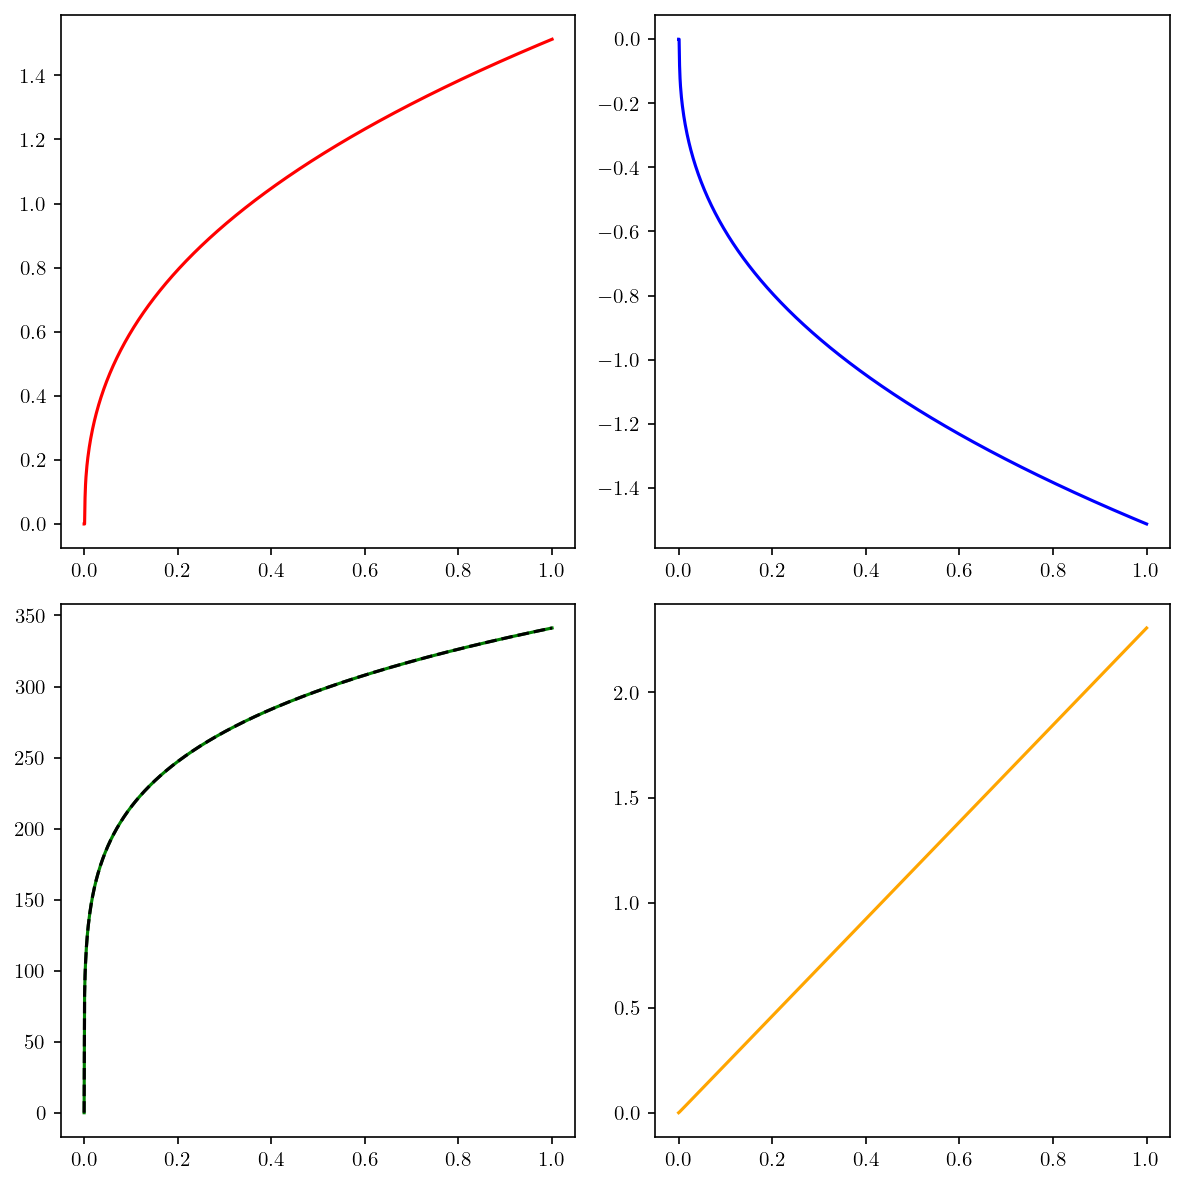

In [85]:
fig, ax = plt.subplots(2,2,figsize=(8,8),dpi=150)

ax[0,0].plot(t,sig[:,0,0]/1e6,label=r'$\sigma_x$',color='red')
ax[0,1].plot(t,sig[:,1,1]/1e6,label=r'$\sigma_x$',color='blue')
ax[1,0].plot(t,sig[:,1,0]/1e6,label=r'$\sigma_x$',color='green')
ax[1,0].plot(t,sig[:,0,1]/1e6,label=r'$\sigma_x$',color='black',ls='--')
ax[1,1].plot(t,λ,label=r'$\sigma_x$',color='orange')

plt.tight_layout()
plt.show()

# Combined simple shear + extension with unloading

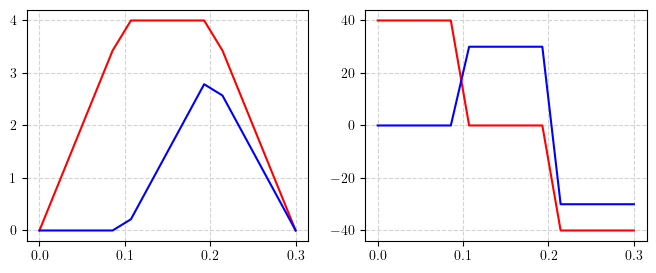

In [172]:
N = 15
t = np.linspace(0,0.3,N)

def ux(t):
    if t <= 0.1: ret = t*40
    elif 0.1 < t <= 0.2: ret = 4
    elif 0.2 < t <= 0.3: ret = 4 - (t-0.2)*40
    return ret

def dux(t):
    if t <= 0.1: ret = 40
    elif 0.1 < t <= 0.2: ret = 0
    elif 0.2 < t <= 0.3: ret = -40
    return ret

def uy(t):
    if t <= 0.1: ret = 0
    elif 0.1 < t <= 0.2: ret = 30*(t-0.1)
    elif 0.2 < t <= 0.3: ret = 3-30*(t-0.2)
    return ret

def duy(t):
    if t <= 0.1: ret = 0
    elif 0.1 < t <= 0.2: ret = 30
    elif 0.2 < t <= 0.3: ret = -30
    return ret

fig, ax = plt.subplots(1,2,figsize=(8,3),dpi=100)

ax[0].plot(t,[ux(ti) for ti in t],color='red')
ax[0].plot(t,[uy(ti) for ti in t],color='blue')
ax[0].grid(ls='--',color='lightgray')
ax[1].plot(t,[dux(ti) for ti in t],color='red')
ax[1].plot(t,[duy(ti) for ti in t],color='blue')
ax[1].grid(ls='--',color='lightgray')
plt.show()

$$
[F] = 
\begin{bmatrix}
    1 & u_x & 0 \\
    0 & 1+u_y & 0 \\
    0 & 0 & 1 \\
\end{bmatrix}
\quad\Rightarrow\quad
\mathbf{F}^{-1} =
\begin{bmatrix}
    1 & -\dfrac{u_x}{1 + u_y} & 0 \\
    0 & \dfrac{1}{1 + u_y} & 0 \\
    0 & 0 & 1 \\
\end{bmatrix}
$$

$$
[l] = [\dot{F}F^{-1}] = 
\begin{bmatrix}
    0 & \dot{u_x} & 0 \\
    0 & \dot{u_y} & 0 \\
    0 & 0 & 0 \\
\end{bmatrix}
\begin{bmatrix}
    1 & -\dfrac{u_x}{1 + u_y} & 0 \\
    0 & \dfrac{1}{1 + u_y} & 0 \\
    0 & 0 & 1 \\
\end{bmatrix}
=
\dfrac{1}{1 + u_y}
\begin{bmatrix}
    0 & \dot{u_x} & 0 \\
    0 & \dot{u_y} & 0 \\
    0 & 0 & 0 \\
\end{bmatrix}
$$

In [173]:
l = lambda t : 1/(1+uy(t)) * np.array([[0,dux(t),0],[0,duy(t),0],[0,0,0]])
d = lambda t: 1/2 * (l(t)+l(t).T)
w = lambda t: l(t) - d(t)

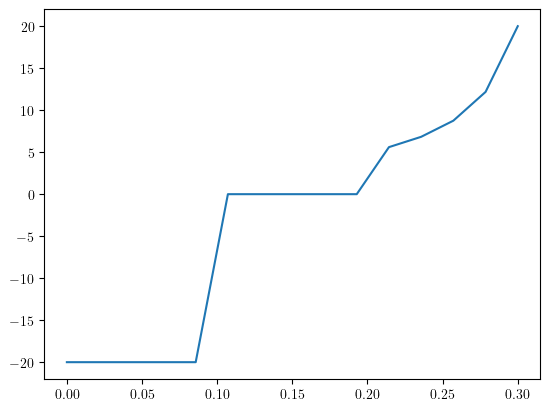

In [176]:
plt.plot(t,[w(ti)[1,0] for ti in t])

In [157]:
E = 200e9
nu = 0.3
G = E/2/(1+nu)

D = lambda d: E/(1+nu) * (d + nu/(1-2*nu)*np.trace(d)*I)

In [158]:
a = 400e6
eps_0  = 0.05
k = 0.25

Y_F = lambda λ : a*(eps_0 + λ)**k

In [159]:
Q = np.tile(I, (N, 1, 1))
sig_tilde = np.tile(O, (N, 1, 1))
sig = np.tile(O, (N, 1, 1))
Y = np.ones(N) * Y_F(0)
λ = np.zeros(N)

for n in range(N-1):
    dt = t[n+1] - t[n]
    t_mid = t[n]+dt/2

    # Hughes-Winget
    Q[n+1] = inv(I - 1/2*w(t_mid)*dt) @ (I + 1/2*w(t_mid)*dt) @ Q[n]
    Q_mid = Q[n+1] # Kossa mondta a videóban, hogy nem kell a középső lépés

    deps_tilde = Q_mid.T @ d(t_mid)* dt @ Q_mid

    # Step 3: trial stress
    sig_trial_tilde = sig_tilde[n] + D(deps_tilde)
    s_trial_tilde = dev(sig_trial_tilde)

    # Step 4: trial yield function
    F_trial = (3/2)**(1/2) * norm(s_trial_tilde) - Y[n]

    if F_trial <= 0:
        # Step 6: Elastic increment
        sig_tilde[n+1] = sig_trial_tilde
        Y[n+1] = Y[n]
        λ[n+1] = λ[n]
    else:
        # Step 7: Accumulated plastic strain increment
        def eq(dλ):
            ret  = (3/2)**(1/2) * norm(s_trial_tilde)
            ret -= 3*G*dλ
            ret -= Y_F(λ[n]+dλ)
            return ret
        dλ = (root(eq,1e-8).x)[0]
        # Step 8: Plastic strain increment and yield stress update
        deps_p_tilde = (3/2)**(1/2) * dλ * s_trial_tilde / norm(s_trial_tilde)
        λ[n+1] = λ[n] + dλ
        Y[n+1] = Y_F(λ[n+1])
        # Step 9: Update the rotated stress
        sig_tilde[n+1] = sig_trial_tilde - D(deps_p_tilde)
    
    # Step 10: Compute the stress tensor
    sig[n+1] = Q[n+1] @ sig_tilde[n+1] @ Q[n+1].T

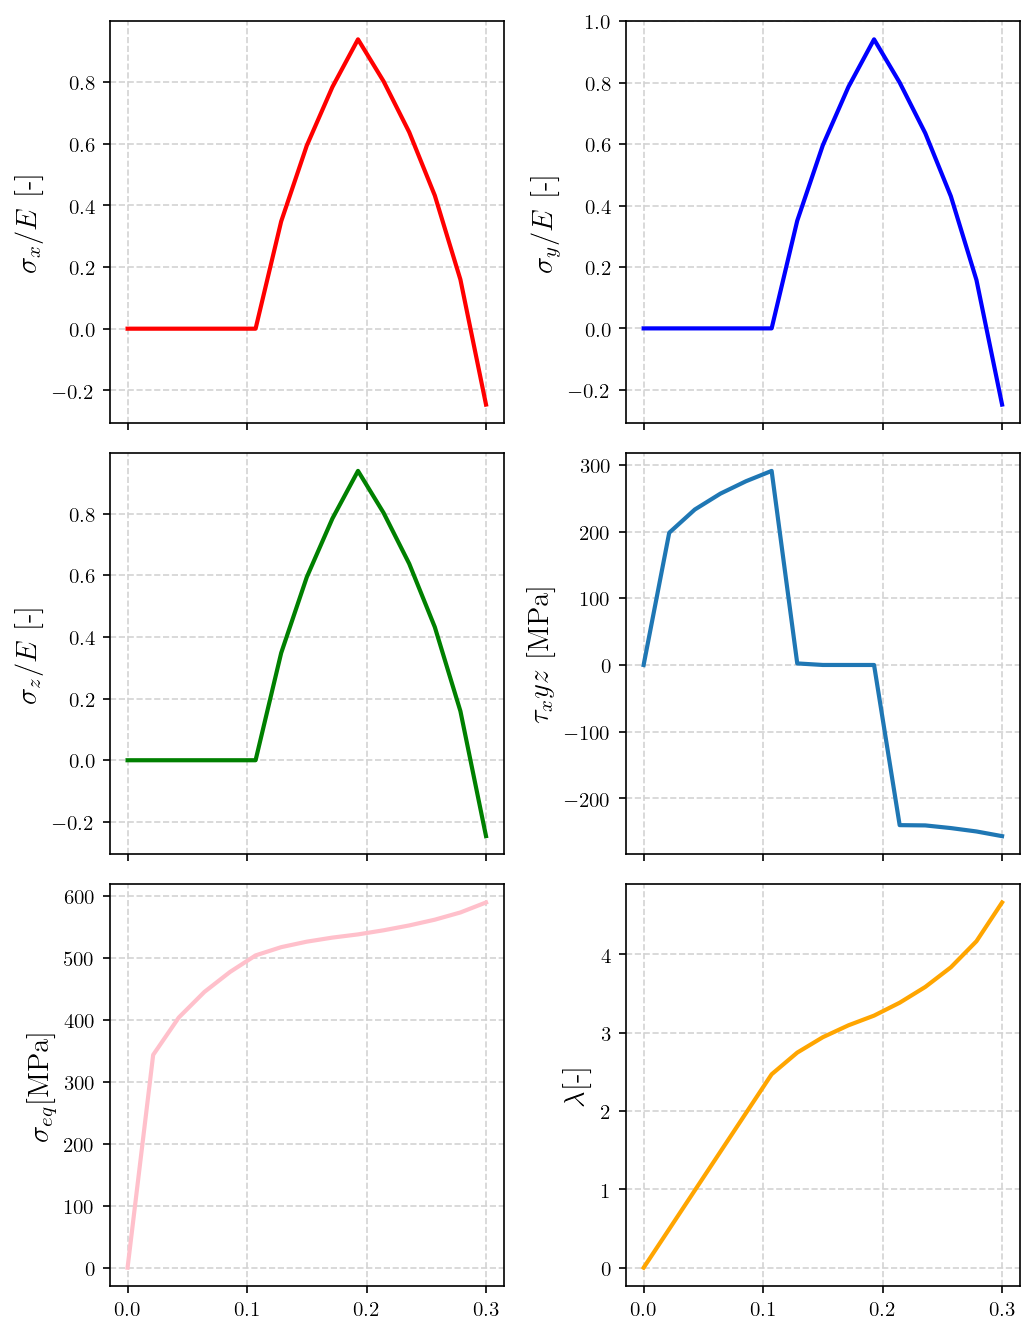

In [160]:
fig, ax = plt.subplots(3,2,figsize=(7,9),dpi=150,sharex=True)

ax[0,0].plot(t,sig[:,0,0]/E,color='red',lw=2)
ax[0,0].set_ylabel(r'$\sigma_x / E$ [-]',fontsize=14)
ax[0,0].grid(ls='--',color='lightgray')

ax[0,1].plot(t,sig[:,1,1]/E,color='blue',lw=2)
ax[0,1].set_ylabel(r'$\sigma_y / E$ [-]',fontsize=14)
ax[0,1].grid(ls='--',color='lightgray')

ax[1,0].plot(t,sig[:,2,2]/E,color='green',lw=2)
ax[1,0].set_ylabel(r'$\sigma_z / E$ [-]',fontsize=14)
ax[1,0].grid(ls='--',color='lightgray')

ax[1,1].plot(t,sig[:,1,0]/1e6,lw=2)
ax[1,1].set_ylabel(r'$\tau_xyz$ [MPa]',fontsize=14)
ax[1,1].grid(ls='--',color='lightgray')

ax[2,0].plot(t,[(3/2)**(1/2)*norm(dev(s))/1e6 for s in sig],color='pink',lw=2)
ax[2,0].set_ylabel(r'$\sigma_{eq} $[MPa]',fontsize=14)
ax[2,0].grid(ls='--',color='lightgray')

ax[2,1].plot(t,λ,label=r'$\sigma_x$',color='orange',lw=2)
ax[2,1].set_ylabel(r'$\lambda $[-]',fontsize=14)
ax[2,1].grid(ls='--',color='lightgray')


plt.tight_layout()
plt.show()

# Homework

In [133]:
N = 15
t = np.concatenate([
    np.linspace(0.0,0.1,N//3),
    np.linspace(0.1,0.2,N//3),
    np.linspace(0.2,0.3,N//3),
])

def uy(t):
    if t <= 0.1: ret = t*40
    elif 0.1 <= t <= 0.2: ret = 4
    elif 0.2 <= t <= 0.3: ret = 4 - (t-0.2)*40
    return ret

def duy(t):
    if t <= 0.1: ret = 40
    elif 0.1 <= t <= 0.2: ret = 0
    elif 0.2 <= t <= 0.3: ret = -40
    return ret

def ux(t):
    if t <= 0.1: ret = 0
    elif 0.1 <= t <= 0.2: ret = 30*(t-0.1)
    elif 0.2 <= t <= 0.3: ret = 3-30*(t-0.2)
    return ret

def dux(t):
    if t <= 0.1: ret = 0
    elif 0.1 <= t <= 0.2: ret = 30
    elif 0.2 <= t <= 0.3: ret = -30
    return ret


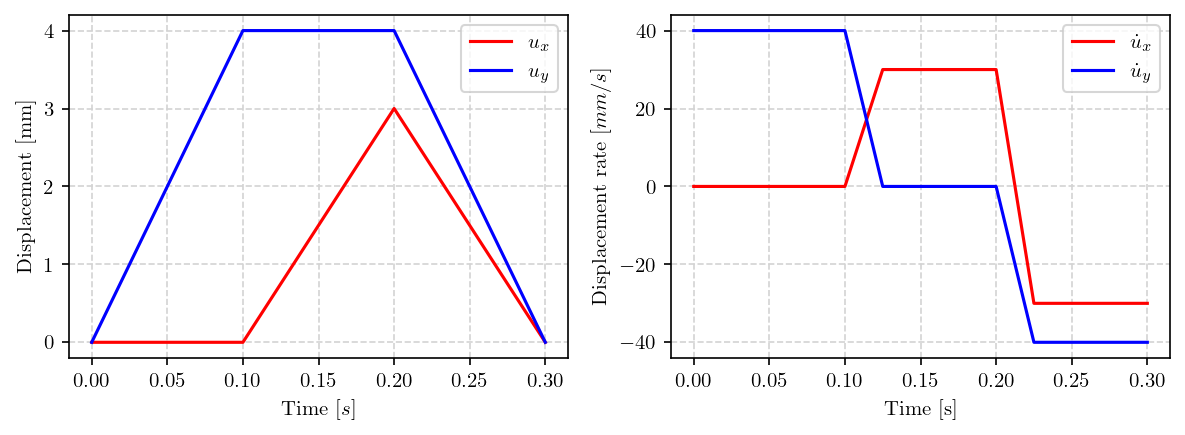

In [120]:
fig, ax = plt.subplots(1,2,figsize=(8,3),dpi=150)

ax[0].plot(t,[ux(ti) for ti in t],color='red',label=r'$u_x$')
ax[0].plot(t,[uy(ti) for ti in t],color='blue',label=r'$u_y$')
ax[0].grid(ls='--',color='lightgray')
ax[0].set_xlabel(r'Time [$s$]')
ax[0].set_ylabel(r'Displacement [mm]')
ax[0].legend()

ax[1].plot(t,[dux(ti) for ti in t],color='red',label=r'$\dot{u}_x$')
ax[1].plot(t,[duy(ti) for ti in t],color='blue',label=r'$\dot{u}_y$')
ax[1].grid(ls='--',color='lightgray')
ax[1].set_xlabel(r'Time [s]')
ax[1].set_ylabel(r'Displacement rate $[mm/s]$')
ax[1].legend()

plt.tight_layout()
plt.show()

In [107]:
l = lambda t : 1/(1+uy(t)) * np.array([[0,dux(t),0],[0,duy(t),0],[0,0,0]])
d = lambda t: 1/2 * (l(t)+l(t).T)
w = lambda t: l(t) - d(t)

In [101]:
E = 200e9
nu = 0.3
G = E/2/(1+nu)

D = lambda d: E/(1+nu) * (d + nu/(1-2*nu)*np.trace(d)*I)\

a = 400e6
eps_0  = 0.05
k = 0.25

Y_F = lambda λ : a*(eps_0 + λ)**k

In [102]:
Q = np.tile(I, (N, 1, 1))
sig_tilde = np.tile(O, (N, 1, 1))
sig = np.tile(O, (N, 1, 1))
Y = np.ones(N) * Y_F(0)
λ = np.zeros(N)

for n in range(N-1):
    dt = t[n+1] - t[n]
    t_mid = t[n]+dt/2

    # Hughes-Winget
    Q[n+1] = inv(I - 1/2*w(t_mid)*dt) @ (I + 1/2*w(t_mid)*dt) @ Q[n]
    Q_mid = Q[n+1] # Kossa mondta a videóban, hogy nem kell a középső lépés

    deps_tilde = Q_mid.T @ d(t_mid)* dt @ Q_mid

    # Step 3: trial stress
    sig_trial_tilde = sig_tilde[n] + D(deps_tilde)
    s_trial_tilde = dev(sig_trial_tilde)

    # Step 4: trial yield function
    F_trial = (3/2)**(1/2) * norm(s_trial_tilde) - Y[n]

    if F_trial <= 0:
        # Step 6: Elastic increment
        sig_tilde[n+1] = sig_trial_tilde
        Y[n+1] = Y[n]
        λ[n+1] = λ[n]
    else:
        # Step 7: Accumulated plastic strain increment
        def eq(dλ):
            ret  = (3/2)**(1/2) * norm(s_trial_tilde)
            ret -= 3*G*dλ
            ret -= Y_F(λ[n]+dλ)
            return ret
        dλ = (root(eq,1e-8).x)[0]
        # Step 8: Plastic strain increment and yield stress update
        deps_p_tilde = (3/2)**(1/2) * dλ * s_trial_tilde / norm(s_trial_tilde)
        λ[n+1] = λ[n] + dλ
        Y[n+1] = Y_F(λ[n+1])
        # Step 9: Update the rotated stress
        sig_tilde[n+1] = sig_trial_tilde - D(deps_p_tilde)
    
    # Step 10: Compute the stress tensor
    sig[n+1] = Q[n+1] @ sig_tilde[n+1] @ Q[n+1].T

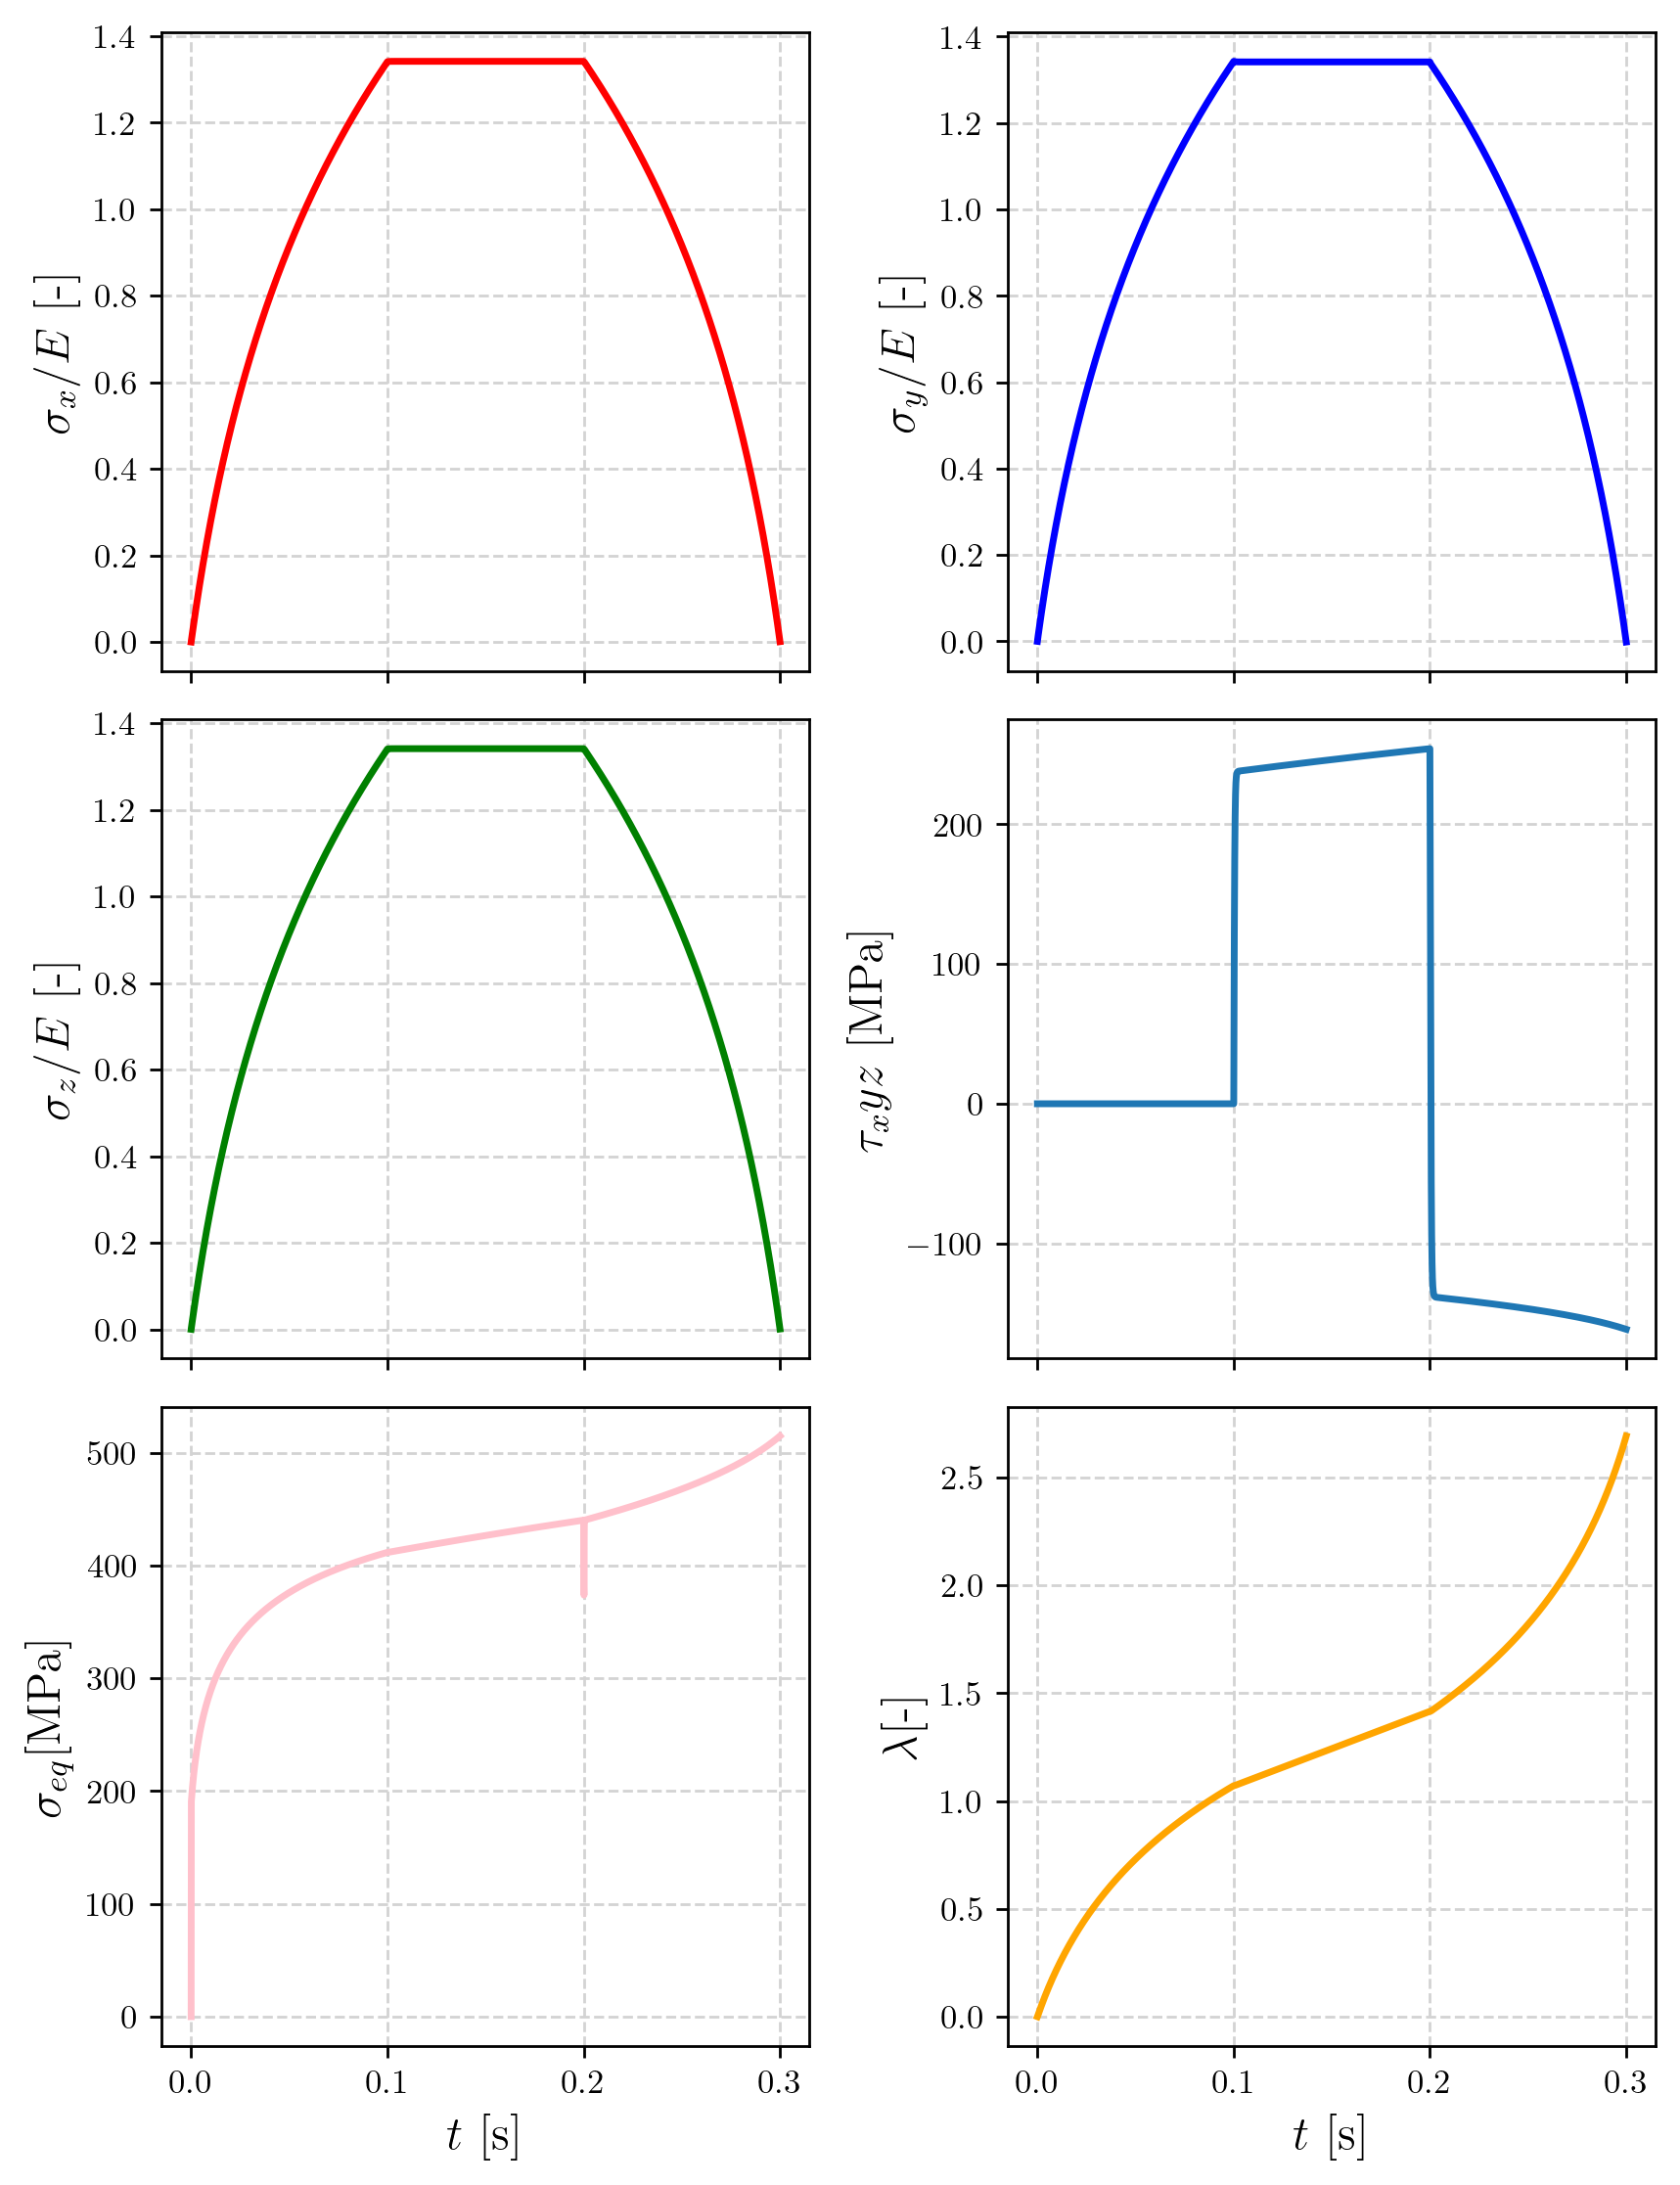

In [104]:
fig, ax = plt.subplots(3,2,figsize=(7,9),dpi=250,sharex=True)

ax[0,0].plot(t,sig[:,0,0]/E,color='red',lw=2)
ax[0,0].set_ylabel(r'$\sigma_x / E$ [-]',fontsize=14)
ax[0,0].grid(ls='--',color='lightgray')

ax[0,1].plot(t,sig[:,1,1]/E,color='blue',lw=2)
ax[0,1].set_ylabel(r'$\sigma_y / E$ [-]',fontsize=14)
ax[0,1].grid(ls='--',color='lightgray')

ax[1,0].plot(t,sig[:,2,2]/E,color='green',lw=2)
ax[1,0].set_ylabel(r'$\sigma_z / E$ [-]',fontsize=14)
ax[1,0].grid(ls='--',color='lightgray')

ax[1,1].plot(t,sig[:,1,0]/1e6,lw=2)
ax[1,1].set_ylabel(r'$\tau_xyz$ [MPa]',fontsize=14)
ax[1,1].grid(ls='--',color='lightgray')

ax[2,0].plot(t,[(3/2)**(1/2)*norm(dev(s))/1e6 for s in sig],color='pink',lw=2)
ax[2,0].set_ylabel(r'$\sigma_{eq} $[MPa]',fontsize=14)
ax[2,0].grid(ls='--',color='lightgray')

ax[2,1].plot(t,λ,label=r'$\sigma_x$',color='orange',lw=2)
ax[2,1].set_ylabel(r'$\lambda $[-]',fontsize=14)
ax[2,1].grid(ls='--',color='lightgray')

ax[2,1].set_xlabel(r'$t$ [s]',fontsize=14)
ax[2,0].set_xlabel(r'$t$ [s]',fontsize=14)

plt.tight_layout()
plt.show()

# Test discrete

In [192]:
N = 15

t = np.concatenate([
    np.linspace(0.0,0.1,N//3),
    np.linspace(0.1,0.2,N//3),
    np.linspace(0.2,0.3,N//3),
])

uy = np.concatenate([
    np.linspace(0,0,N//3),
    np.linspace(0,3,N//3),
    np.linspace(3,0,N//3),
])

duy = np.concatenate([
      0*np.ones(N//3),
     30*np.ones(N//3),
    -30*np.ones(N//3),
])

ux = np.concatenate([
    np.linspace(0,4,N//3),
    np.linspace(4,4,N//3),
    np.linspace(4,0,N//3),
])

dux = np.concatenate([
     40*np.ones(N//3),
      0*np.ones(N//3),
    -40*np.ones(N//3),
])

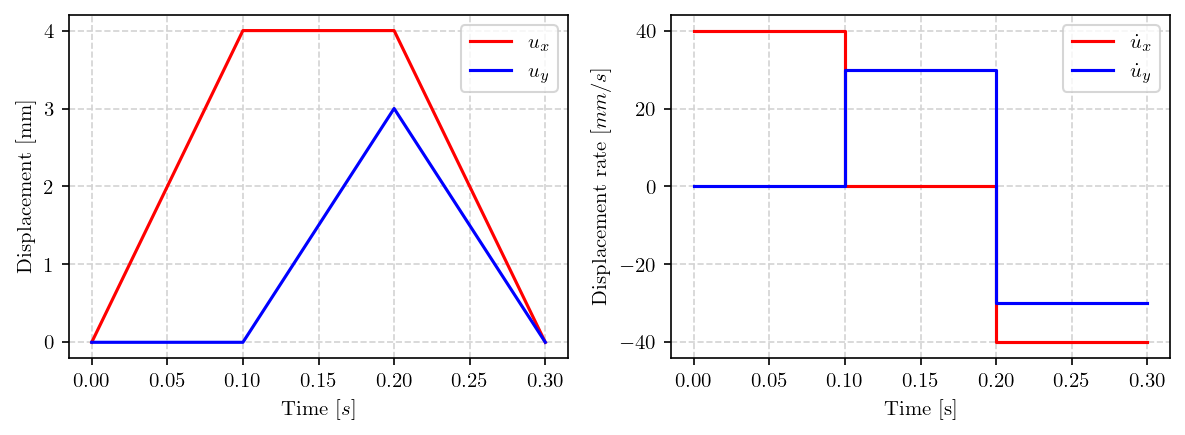

In [193]:
fig, ax = plt.subplots(1,2,figsize=(8,3),dpi=150)

ax[0].plot(t,ux,color='red',label=r'$u_x$')
ax[0].plot(t,uy,color='blue',label=r'$u_y$')
ax[0].grid(ls='--',color='lightgray')
ax[0].set_xlabel(r'Time [$s$]')
ax[0].set_ylabel(r'Displacement [mm]')
ax[0].legend()

ax[1].plot(t,dux,color='red',label=r'$\dot{u}_x$')
ax[1].plot(t,duy,color='blue',label=r'$\dot{u}_y$')
ax[1].grid(ls='--',color='lightgray')
ax[1].set_xlabel(r'Time [s]')
ax[1].set_ylabel(r'Displacement rate $[mm/s]$')
ax[1].legend()

plt.tight_layout()
plt.show()

In [194]:
l = np.array([1/(1+uy[n]) * np.array([[0,dux[n],0],[0,duy[n],0],[0,0,0]]) for n in range(N)])
d = 1/2*(l + l.transpose(0,2,1))
w = l - d

In [195]:
E = 200e9
nu = 0.3
G = E/2/(1+nu)

D = lambda d: E/(1+nu) * (d + nu/(1-2*nu)*np.trace(d)*I)

a = 400e6
eps_0  = 0.05
k = 0.25

Y_F = lambda λ : a*(eps_0 + λ)**k

In [196]:
Q = np.tile(I, (N, 1, 1))
sig_tilde = np.tile(O, (N, 1, 1))
sig = np.tile(O, (N, 1, 1))
Y = np.ones(N) * Y_F(0)
λ = np.zeros(N)

for n in range(N-1):
    dt = t[n+1] - t[n]

    w_mid = (w[n+1] + w[n])/2
    d_mid = (d[n+1] + d[n])/2

    # Hughes-Winget
    Q[n+1] = inv(I - 1/2*w_mid*dt) @ (I + 1/2*w_mid*dt) @ Q[n]
    Q_mid = Q[n+1] # Kossa mondta a videóban, hogy nem kell a középső lépés

    deps_tilde = Q_mid.T @ d_mid* dt @ Q_mid

    # Step 3: trial stress
    sig_trial_tilde = sig_tilde[n] + D(deps_tilde)
    s_trial_tilde = dev(sig_trial_tilde)

    # Step 4: trial yield function
    F_trial = (3/2)**(1/2) * norm(s_trial_tilde) - Y[n]

    if F_trial <= 0:
        # Step 6: Elastic increment
        sig_tilde[n+1] = sig_trial_tilde
        Y[n+1] = Y[n]
        λ[n+1] = λ[n]
    else:
        # Step 7: Accumulated plastic strain increment
        def eq(dλ):
            ret  = (3/2)**(1/2) * norm(s_trial_tilde)
            ret -= 3*G*dλ
            ret -= Y_F(λ[n]+dλ)
            return ret
        dλ = (root(eq,1e-8).x)[0]
        # Step 8: Plastic strain increment and yield stress update
        deps_p_tilde = (3/2)**(1/2) * dλ * s_trial_tilde / norm(s_trial_tilde)
        λ[n+1] = λ[n] + dλ
        Y[n+1] = Y_F(λ[n+1])
        # Step 9: Update the rotated stress
        sig_tilde[n+1] = sig_trial_tilde - D(deps_p_tilde)
    
    # Step 10: Compute the stress tensor
    sig[n+1] = Q[n+1] @ sig_tilde[n+1] @ Q[n+1].T

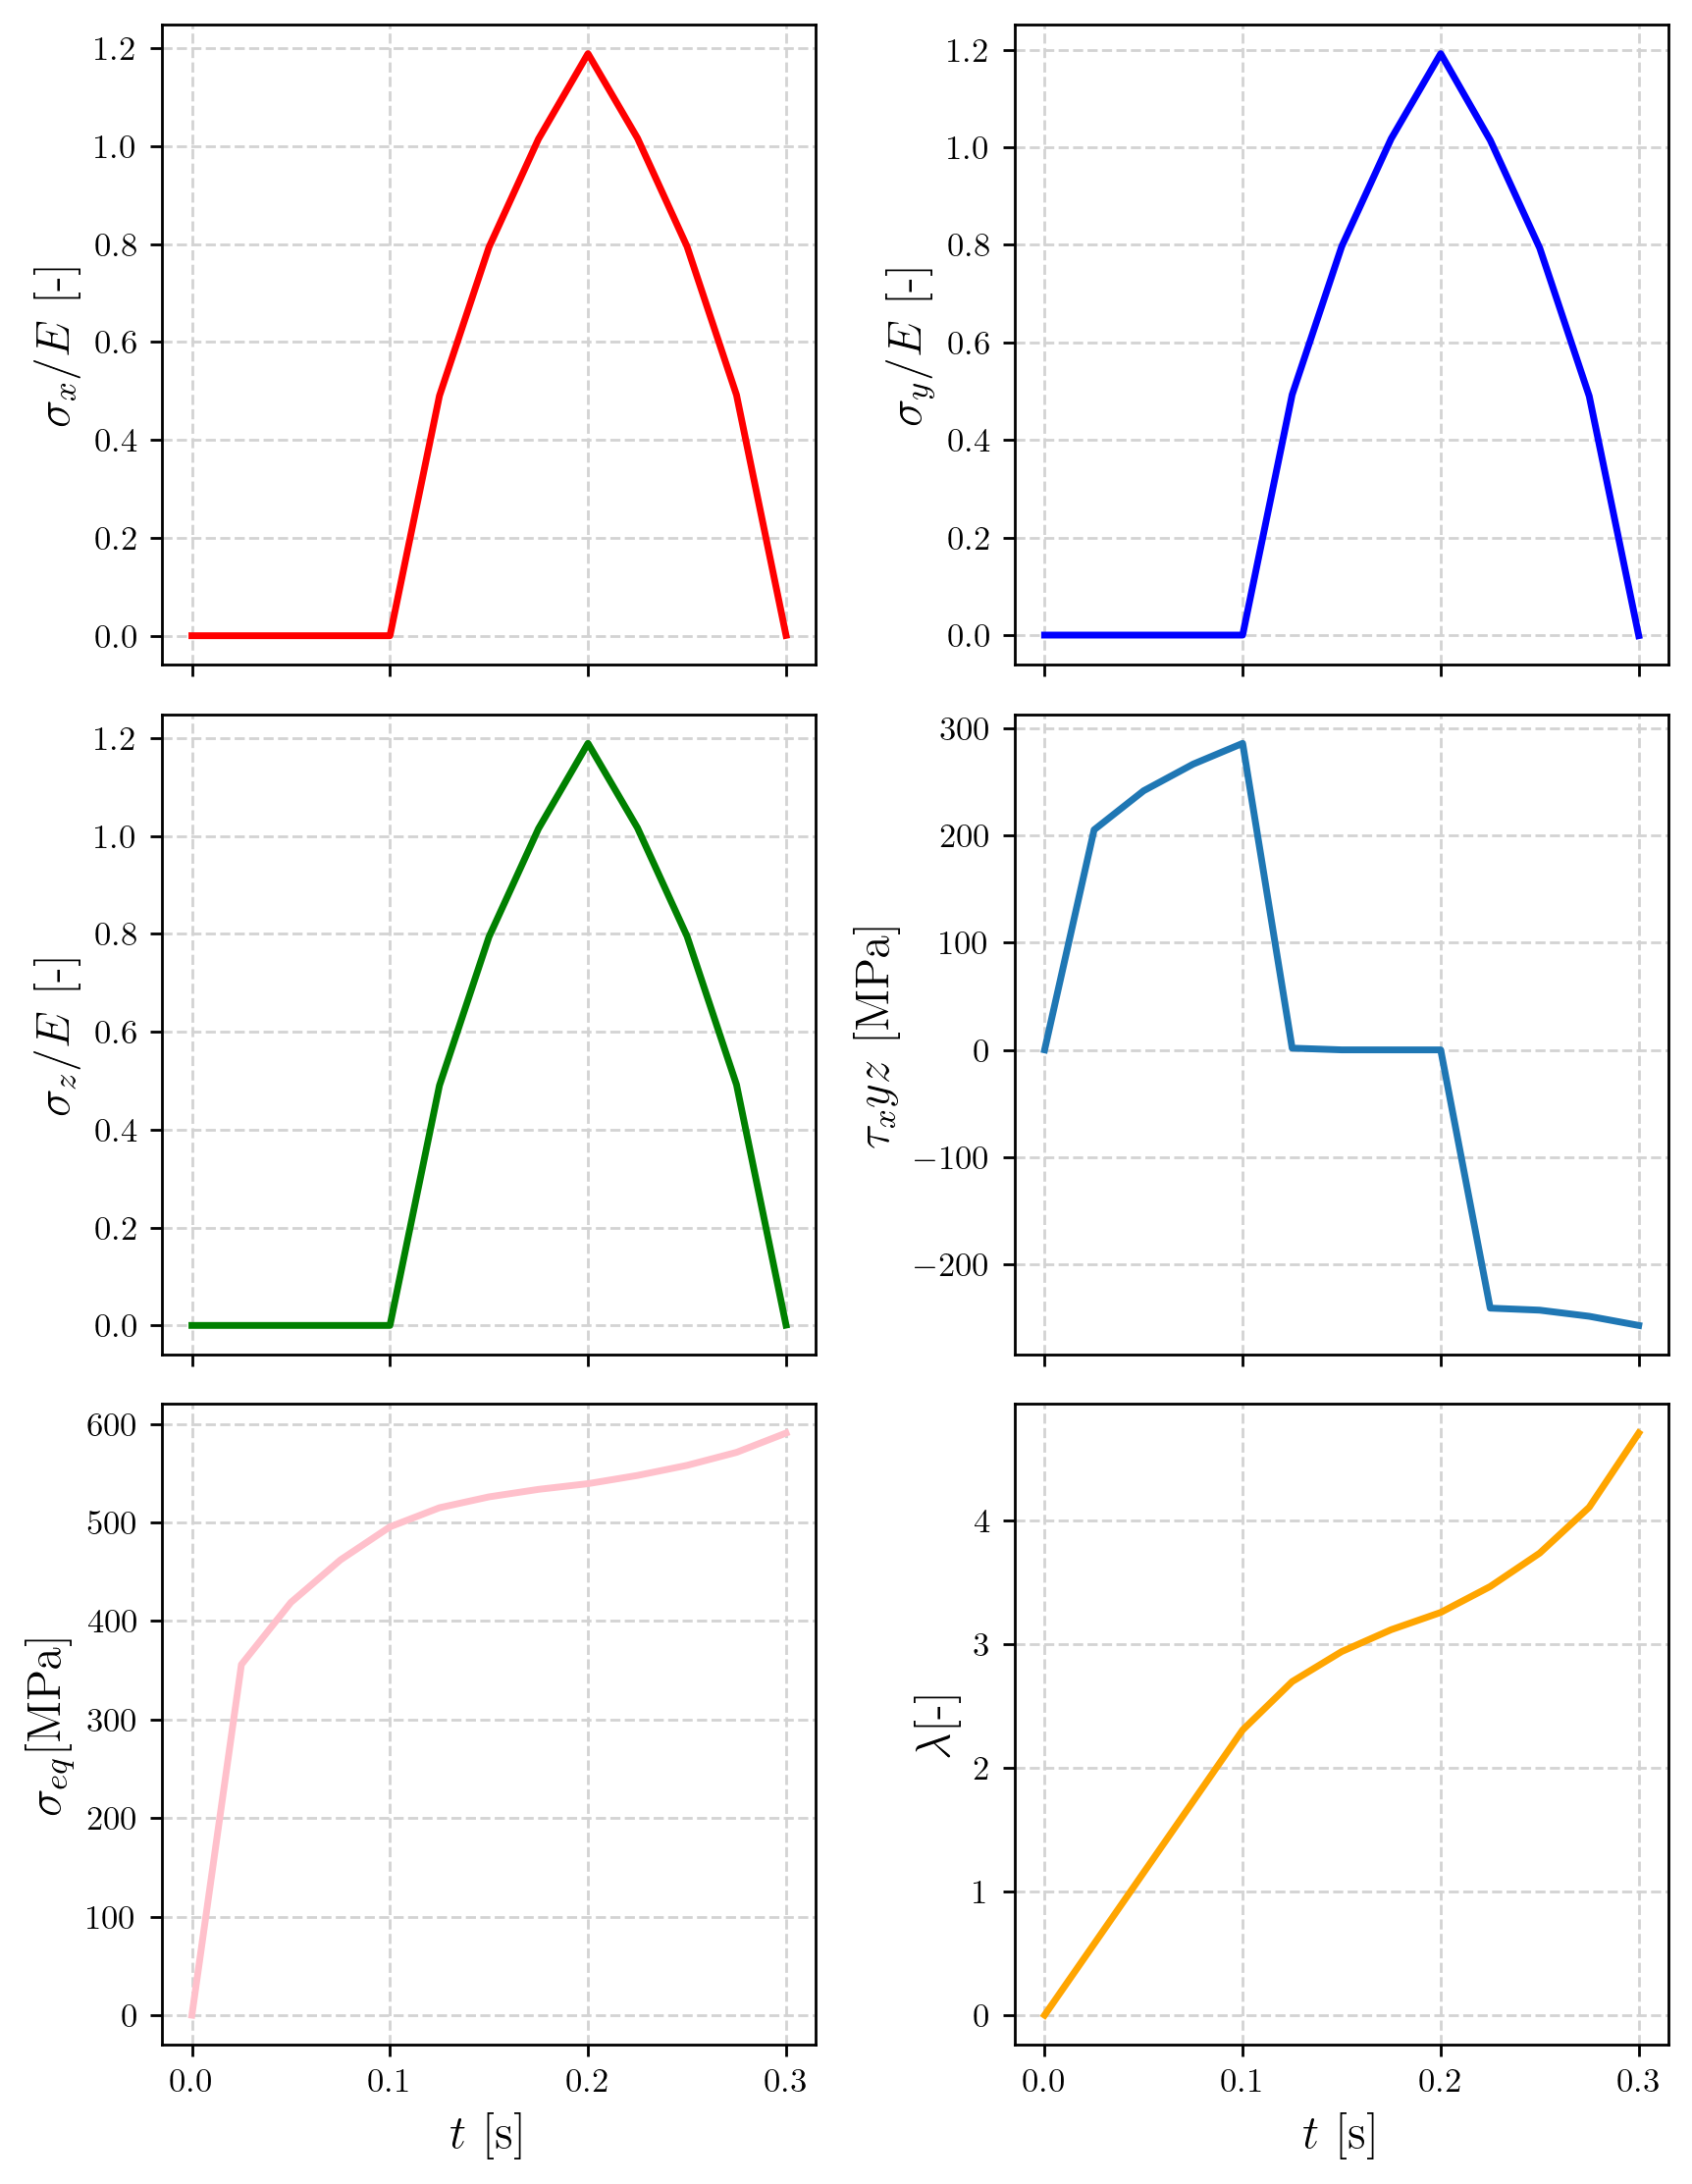

In [197]:
fig, ax = plt.subplots(3,2,figsize=(7,9),dpi=250,sharex=True)

ax[0,0].plot(t,sig[:,0,0]/E,color='red',lw=2)
ax[0,0].set_ylabel(r'$\sigma_x / E$ [-]',fontsize=14)
ax[0,0].grid(ls='--',color='lightgray')

ax[0,1].plot(t,sig[:,1,1]/E,color='blue',lw=2)
ax[0,1].set_ylabel(r'$\sigma_y / E$ [-]',fontsize=14)
ax[0,1].grid(ls='--',color='lightgray')

ax[1,0].plot(t,sig[:,2,2]/E,color='green',lw=2)
ax[1,0].set_ylabel(r'$\sigma_z / E$ [-]',fontsize=14)
ax[1,0].grid(ls='--',color='lightgray')

ax[1,1].plot(t,sig[:,1,0]/1e6,lw=2)
ax[1,1].set_ylabel(r'$\tau_xyz$ [MPa]',fontsize=14)
ax[1,1].grid(ls='--',color='lightgray')

ax[2,0].plot(t,[(3/2)**(1/2)*norm(dev(s))/1e6 for s in sig],color='pink',lw=2)
ax[2,0].set_ylabel(r'$\sigma_{eq} $[MPa]',fontsize=14)
ax[2,0].grid(ls='--',color='lightgray')

ax[2,1].plot(t,λ,label=r'$\sigma_x$',color='orange',lw=2)
ax[2,1].set_ylabel(r'$\lambda $[-]',fontsize=14)
ax[2,1].grid(ls='--',color='lightgray')

ax[2,1].set_xlabel(r'$t$ [s]',fontsize=14)
ax[2,0].set_xlabel(r'$t$ [s]',fontsize=14)

plt.tight_layout()
plt.show()

# Homework discrete

In [224]:
N = 15

t = np.concatenate([
    np.linspace(0.0,0.1,N//3),
    np.linspace(0.1,0.2,N//3),
    np.linspace(0.2,0.3,N//3),
])

ux = np.concatenate([
    np.linspace(0,0,N//3),
    np.linspace(0,3,N//3),
    np.linspace(3,0,N//3),
])

dux = np.concatenate([
      0*np.ones(N//3),
     30*np.ones(N//3),
    -30*np.ones(N//3),
])

uy = np.concatenate([
    np.linspace(0,4,N//3),
    np.linspace(4,4,N//3),
    np.linspace(4,0,N//3),
])

duy = np.concatenate([
     40*np.ones(N//3),
      0*np.ones(N//3),
    -40*np.ones(N//3),
])

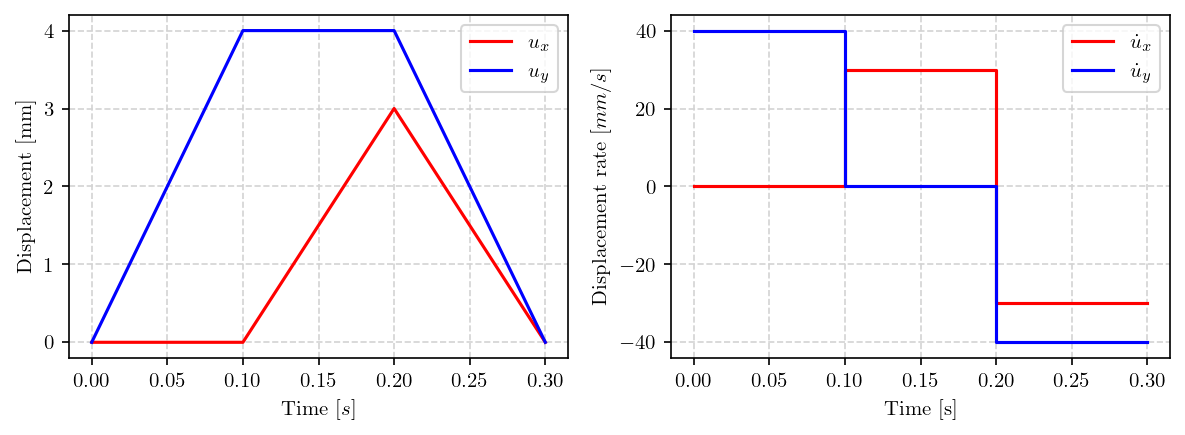

In [225]:
fig, ax = plt.subplots(1,2,figsize=(8,3),dpi=150)

ax[0].plot(t,ux,color='red',label=r'$u_x$')
ax[0].plot(t,uy,color='blue',label=r'$u_y$')
ax[0].grid(ls='--',color='lightgray')
ax[0].set_xlabel(r'Time [$s$]')
ax[0].set_ylabel(r'Displacement [mm]')
ax[0].legend()

ax[1].plot(t,dux,color='red',label=r'$\dot{u}_x$')
ax[1].plot(t,duy,color='blue',label=r'$\dot{u}_y$')
ax[1].grid(ls='--',color='lightgray')
ax[1].set_xlabel(r'Time [s]')
ax[1].set_ylabel(r'Displacement rate $[mm/s]$')
ax[1].legend()

plt.tight_layout()
plt.show()

In [226]:
l = np.array([1/(1+uy[n]) * np.array([[0,dux[n],0],[0,duy[n],0],[0,0,0]]) for n in range(N)])
d = 1/2*(l + l.transpose(0,2,1))
w = l - d

In [227]:
E = 200e9
nu = 0.3
G = E/2/(1+nu)

D = lambda d: E/(1+nu) * (d + nu/(1-2*nu)*np.trace(d)*I)

a = 400e6
eps_0  = 0.05
k = 0.25

Y_F = lambda λ : a*(eps_0 + λ)**k

In [228]:
Q = np.tile(I, (N, 1, 1))
sig_tilde = np.tile(O, (N, 1, 1))
sig = np.tile(O, (N, 1, 1))
Y = np.ones(N) * Y_F(0)
λ = np.zeros(N)

for n in range(N-1):
    dt = t[n+1] - t[n]

    w_mid = (w[n+1] + w[n])/2
    d_mid = (d[n+1] + d[n])/2

    # Hughes-Winget
    Q[n+1] = inv(I - 1/2*w_mid*dt) @ (I + 1/2*w_mid*dt) @ Q[n]
    Q_mid = Q[n+1] # Kossa mondta a videóban, hogy nem kell a középső lépés

    deps_tilde = Q_mid.T @ d_mid* dt @ Q_mid

    # Step 3: trial stress
    sig_trial_tilde = sig_tilde[n] + D(deps_tilde)
    s_trial_tilde = dev(sig_trial_tilde)

    # Step 4: trial yield function
    F_trial = (3/2)**(1/2) * norm(s_trial_tilde) - Y[n]

    if F_trial <= 0:
        # Step 6: Elastic increment
        sig_tilde[n+1] = sig_trial_tilde
        Y[n+1] = Y[n]
        λ[n+1] = λ[n]
    else:
        # Step 7: Accumulated plastic strain increment
        def eq(dλ):
            ret  = (3/2)**(1/2) * norm(s_trial_tilde)
            ret -= 3*G*dλ
            ret -= Y_F(λ[n]+dλ)
            return ret
        dλ = (root(eq,1e-8).x)[0]
        # Step 8: Plastic strain increment and yield stress update
        deps_p_tilde = (3/2)**(1/2) * dλ * s_trial_tilde / norm(s_trial_tilde)
        λ[n+1] = λ[n] + dλ
        Y[n+1] = Y_F(λ[n+1])
        # Step 9: Update the rotated stress
        sig_tilde[n+1] = sig_trial_tilde - D(deps_p_tilde)
    
    # Step 10: Compute the stress tensor
    sig[n+1] = Q[n+1] @ sig_tilde[n+1] @ Q[n+1].T

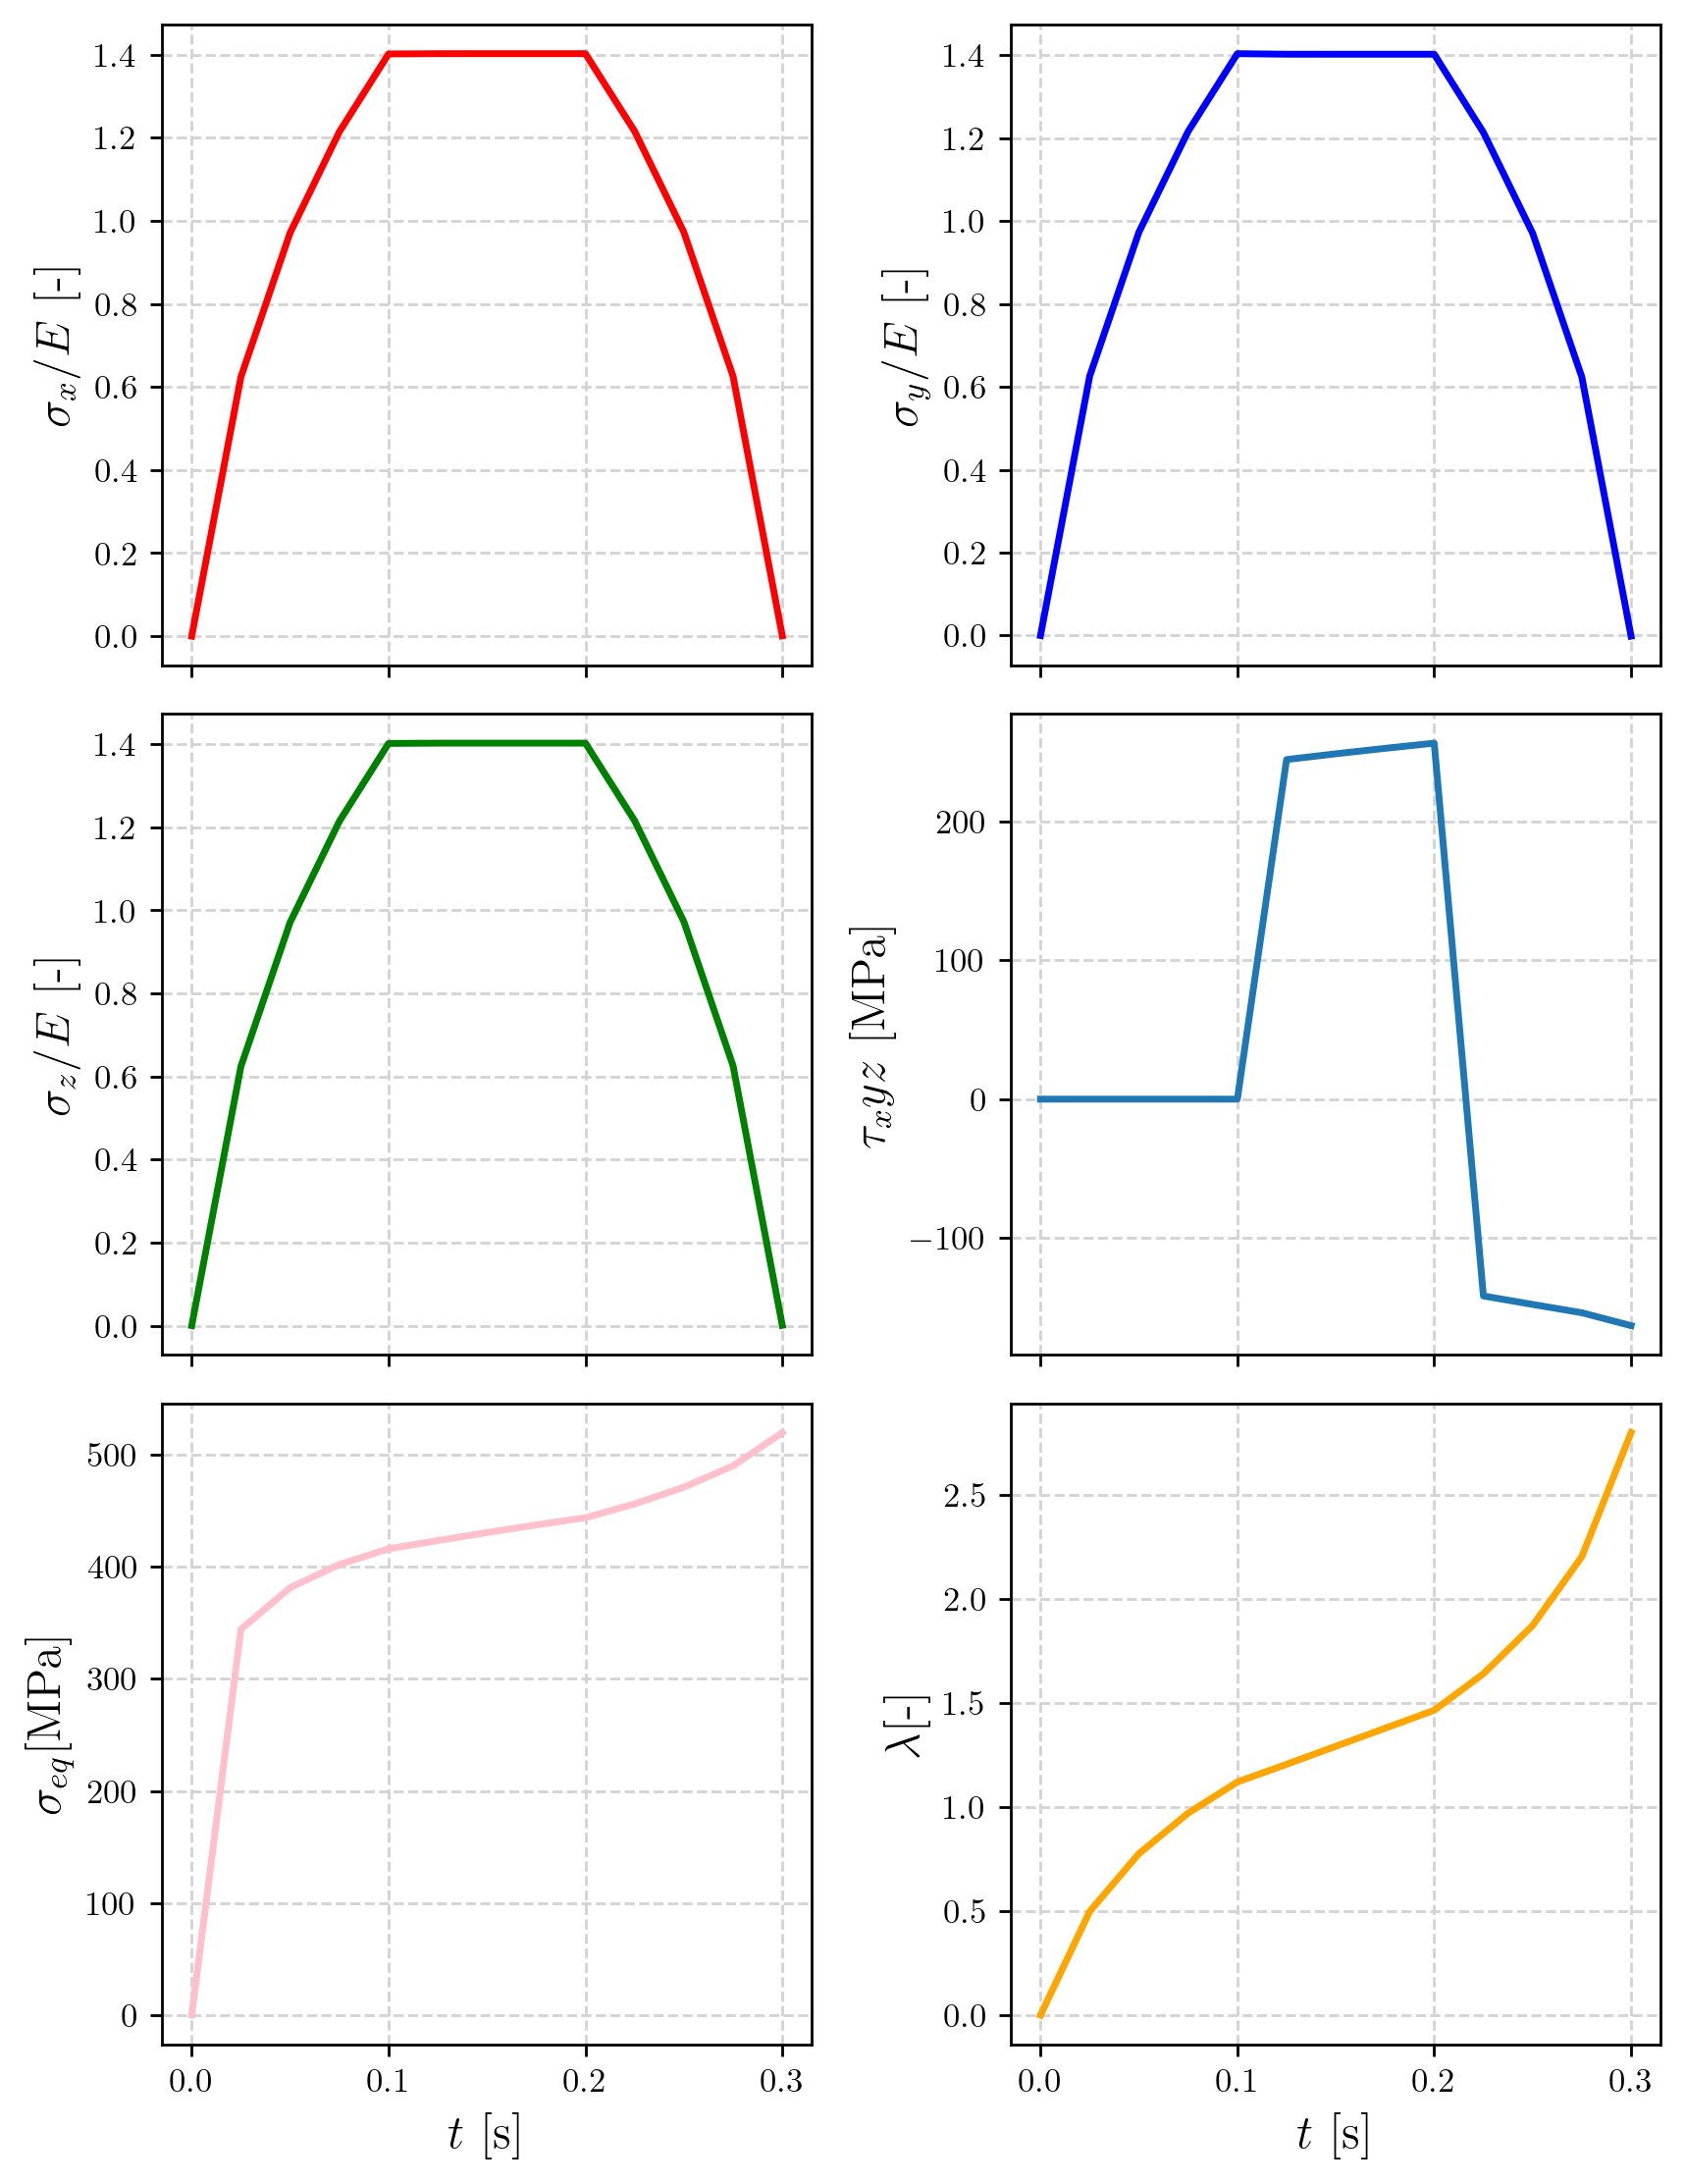

In [229]:
fig, ax = plt.subplots(3,2,figsize=(7,9),dpi=250,sharex=True)

ax[0,0].plot(t,sig[:,0,0]/E,color='red',lw=2)
ax[0,0].set_ylabel(r'$\sigma_x / E$ [-]',fontsize=14)
ax[0,0].grid(ls='--',color='lightgray')

ax[0,1].plot(t,sig[:,1,1]/E,color='blue',lw=2)
ax[0,1].set_ylabel(r'$\sigma_y / E$ [-]',fontsize=14)
ax[0,1].grid(ls='--',color='lightgray')

ax[1,0].plot(t,sig[:,2,2]/E,color='green',lw=2)
ax[1,0].set_ylabel(r'$\sigma_z / E$ [-]',fontsize=14)
ax[1,0].grid(ls='--',color='lightgray')

ax[1,1].plot(t,sig[:,1,0]/1e6,lw=2)
ax[1,1].set_ylabel(r'$\tau_xyz$ [MPa]',fontsize=14)
ax[1,1].grid(ls='--',color='lightgray')

ax[2,0].plot(t,[(3/2)**(1/2)*norm(dev(s))/1e6 for s in sig],color='pink',lw=2)
ax[2,0].set_ylabel(r'$\sigma_{eq} $[MPa]',fontsize=14)
ax[2,0].grid(ls='--',color='lightgray')

ax[2,1].plot(t,λ,label=r'$\sigma_x$',color='orange',lw=2)
ax[2,1].set_ylabel(r'$\lambda $[-]',fontsize=14)
ax[2,1].grid(ls='--',color='lightgray')

ax[2,1].set_xlabel(r'$t$ [s]',fontsize=14)
ax[2,0].set_xlabel(r'$t$ [s]',fontsize=14)

plt.tight_layout()
plt.show()

In [230]:
import pandas as pd

data = {
    "Time (s)": t,
    "Sigma_x / E (-)": sig[:, 0, 0] / E,
    "Sigma_y / E (-)": sig[:, 1, 1] / E,
    "Sigma_z / E (-)": sig[:, 2, 2] / E,
    "Tau_xyz (MPa)": sig[:, 1, 0] / 1e6,
    "Sigma_eq (MPa)": [(3/2)**(1/2) * norm(dev(s)) / 1e6 for s in sig],
    "Lambda (-)": λ
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv(f"{N//3}_incr_solution.csv", index=False)